<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_05_TransferLearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning



In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-01 09:22:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-01 09:22:07 (92.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem



Get the 10% Foor dataset

In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-01 09:22:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   277MB/s    in 0.6s    

2023-06-01 09:22:12 (277 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [5]:
# Create training and test direcotry paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,

)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent # NONE is insterted due to the batch sie

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.26984695e+02 2.44397949e+02 1.98158173e+02]
   [2.25857132e+02 2.43857132e+02 1.94000000e+02]
   [2.29857132e+02 2.49933670e+02 1.96704086e+02]
   ...
   [1.83494812e+02 2.35066284e+02 1.99280548e+02]
   [1.82188797e+02 2.36188797e+02 2.00188797e+02]
   [1.80928467e+02 2.36101974e+02 1.99515228e+02]]

  [[2.28903061e+02 2.48903061e+02 1.96096939e+02]
   [2.26285706e+02 2.46285706e+02 1.93295914e+02]
   [2.30586731e+02 2.51229584e+02 1.99872452e+02]
   ...
   [1.86387695e+02 2.36499939e+02 2.01015289e+02]
   [1.85846954e+02 2.37857162e+02 2.01857162e+02]
   [1.86025452e+02 2.38831635e+02 2.02831635e+02]]

  [[2.23714294e+02 2.48928574e+02 1.90285721e+02]
   [2.23000000e+02 2.46484680e+02 1.90142853e+02]
   [2.27260193e+02 2.49596939e+02 2.00903061e+02]
   ...
   [1.89336716e+02 2.38188812e+02 2.02806183e+02]
   [1.89943863e+02 2.39301010e+02 2.04086731e+02]
   [1.88147934e+02 2.37505081e+02 2.02719360e+02]]

  ...

  [[2.42000061e+02 2.52428589e+02 4.22244301e+01]
   [2

Keras Sequential vs FUnctional API

* Functional API is more flexible

## Model 0 : Building a transfer learning feature extraction model with Functional API

The sequential API is straight forward, but the functional API Gives us more flexibility with our models

In [10]:
#1. Create the base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(
    include_top=False,

)

# 2. Freeze the base model(the underlying pre-trained patterns aren't modified )

base_model.trainable=False

#3. Create the input into our odel
inputs =  tf.keras.layers.Input(shape=(224,224,3), name='Input layer')

#4. If using Resnet50V2 you will need to normalize inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs to our base model{x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most importantinformation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"shape after global averagepooling2D:{x.shape}")

#7. Create the otput activation layer
outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8 Comibe the inputs with the outputs into a model
model_0=tf.keras.Model(inputs, outputs)

#9 Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
#10. Fit the model and save it's history
istory_10_percent= model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name='10_percent')])




16705208/16705208 [==============================] - 0s 0us/step


shape after passing inputs to our base model(None, 7, 7, 1280)
shape after global averagepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230601-092220
Epoch 1/5
24/24 [==============================] - 19s 226ms/step - loss: 1.9030 - accuracy: 0.3933 - val_loss: 1.2888 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 5s 175ms/step - loss: 1.1051 - accuracy: 0.7520 - val_loss: 0.8392 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 4s 174ms/step - loss: 0.7902 - accuracy: 0.8093 - val_loss: 0.6869 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6449 - accuracy: 0.8533 - val_loss: 0.6231 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 173ms/step - loss: 0.5584 - accuracy: 0.8747 - val_loss: 0.5588 - val_accuracy: 0.8635


In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5565 - accuracy: 0.8656


[0.5565467476844788, 0.8655999898910522]

In [12]:
#Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7facdd4d1f60>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7facdd4d35b0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7facdd9ec4c0>
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7facdd9b3760>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7facdd5c8970>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7facdd5c8af0>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7facdd5ca5c0>
7 <keras.layers.core.activation.Activation object at 0x7facdd5c9d50>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7facdd5cb220>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7facdd9b3e50>
10 <keras.layers.core.activation.Activation object at 0x7facdd5c95a0>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7facdc0d93f0>
12 <keras.l

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

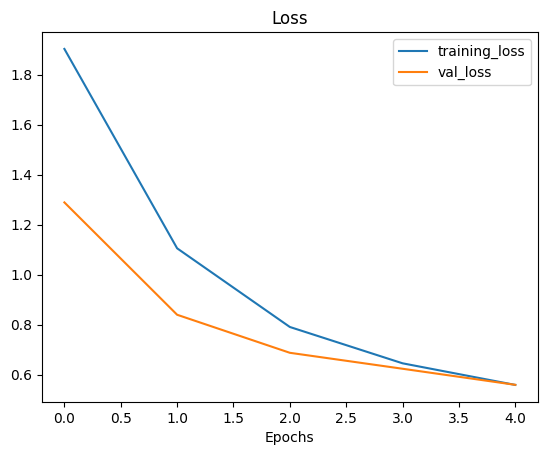

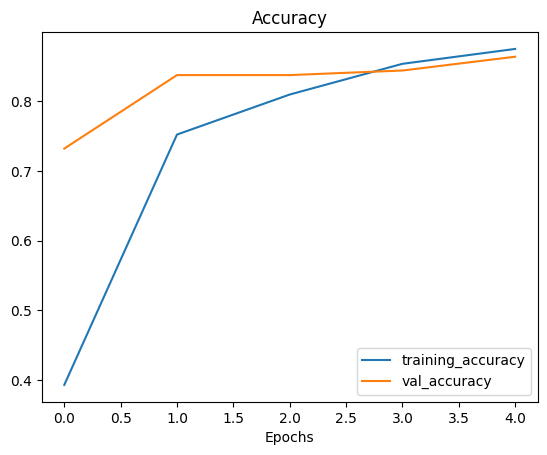

In [15]:
plot_loss_curves(istory_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a ensor after our model goes through 'base model' of shape (None, 7,7 , 1280).

But then it passes through GlobalAveragePooling2D, it turns into (None,1280).

let's use a similar shaped tensor (1,4,4,2) and the pass it through GlobalAverage2D.


In [21]:
input_shape=(1,4,4,3)

#Create a Random Tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print("Random Input Tensor {}".format(input_tensor))



Random Input Tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [22]:
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [23]:
print(global_average_pooled_tensor)

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


In [24]:
print(f"Shape of input tensor{input_tensor.shape} and shapeof averagePooled Tensor{global_average_pooled_tensor.shape}")

Shape of input tensor(1, 4, 4, 3) and shapeof averagePooled Tensor(1, 3)
